<a href="https://colab.research.google.com/github/amey-joshi/am/blob/master/p4/m2p_C01_Adaptive_Stochastic_Gradient_Descent_Optimisation_for_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
**Image registration** consists of matching two images of the same object that are taken in different configurations, or at different times or using different cameras. An example of the first case is when we are trying to match an image of an object in motion with the same object at rest. An example of the second case is a satellite taking images of the same patch of earth's surface at different times. An example of the third case is when one is trying to match a CT image of a portion of a certain patient with an MR image of the same portion of the same patient. In each case, we want to transform one of the images into another in 'the best possible' way. The word 'best' indicates that mathematically, image registration is an optimization problem.

In this tutorial, we will use the first case as an example of image registration. That is, we will try to match a moving image with a fixed one. Define the fixed image by the mapping $F: \Omega_F \subset \mathbb{R}^D \mapsto \mathbb{R}$. Thus, the function $F$ maps a point $x$ in the subset $\Omega_F$ of $D$-dimensional points to a real number. Similarly, let the moving image be defined by the mapping $M: \Omega_M \subset \mathbb{R}^D \mapsto \mathbb{R}$. Consider the mapping $T: \Omega_F \times \mathbb{R}^p \mapsto \Omega_M$, where $\mathbb{R}^p$ is the space of parameters. If $\mu \in \mathbb{R}^p$ then $T(x, \mu) = y$ maps a point $x \in \Omega_F$, the domain of the fixed image and a certain values of parameters $\mu$ to a point $y \in \Omega_M$. 

Before proceeding, let us spend some time understanding this mathematical notation. As a concrete example, let $D = 3$, that is $\Omega_F$, the domain of the fixed image, is a subset of the three dimensional euclidean space. The transformation $T$ will typically have a certain number of parameters. For example, we may try to fit $ax + b$ to $y$. Thus, we want to find the 'best' $a$ and $b$ so that $ax + b$ is closest to $y$. In this case, the transformation space if two dimensional, or $p = 2$.

The idea of a match is expressed in terms of a cost function $\mathcal{C}$. A commonly used cost function is the root mean square error between the fixed and the moving images. Thus, we may define
$$
  \mathcal{C}(F, M) = \left(\sum_{x \in \Omega_F}||x - T(x, \mu)||^2\right)^{1/2},
$$
where $F$ is the fixed image and $M$ is the moving image. Note that in order to compute $\mathcal{C}(X, Y)$, we have to add $||x - T(x, \mu)||^2$ over **all** points and then take the square root. A typical $512 \times 512$ image will involve summing over $512^2 = 261144$ points. Thus, computation of $C$ is usually an expensive operation.

The optimization problem is to find those parameters $\mu \in \mathbb{R}^p$ that **minimize** the cost $\mathcal{C}(F, M)$. Note the similarity between this problem and the simple case of fitting a line using least square method. The image registration problem can be mathematically expressed as
$$\tag{1}
\hat{\mu} = \mathrm{argmin}_{\mu}\;\mathcal{C}(F, M \circ T).
$$
Equation (1) says, $\hat{\mu}$ is that value of the parameters that minimizes $\mathcal{C}(F, M \circ T)$. Let us understand the $M \circ T$ part. If $x$ is a point in the domain $\Omega_F$ of the fixed image then $(M \circ T)(x) = M(T(x, \mu))$. For a certain value of the parameters $\mu$, $T$ maps a point $x \in \Omega_F$ to a point, say $y$ in the domain $\Omega_M$ of the moving image. Recall the definition of the transformation $T$ as a mapping $T: \Omega_F \times \mathbb{R}^p \mapsto \Omega_M$. Thus $M(T(x, \mu)) = M(y)$, a point in the moving image. Thus, the composite function $M \circ T$ maps a point of the fixed image to a point in the moving image. The optimization problem consists in finding the set of parameters which minimize the cost function.


## Gradient descent

This tutorial uses the **adaptive stochastic gradient descent algorithm** to solve the optimization problem defined by equation (1). We shall explain the algorithm by telling its evolution from **gradient descent** to **stochastic gradient descent** and finally to **adaptive stochastic gradient descent** by explaining the ideas using an example of a simple function defined over one variable. Consider the function shown below.

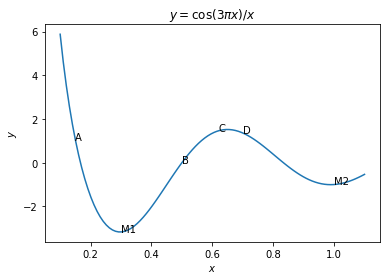

In [0]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0.1, 1.1, 100)
y = np.divide(np.cos(3 * np.pi * x), x)

def f(x):
  return np.cos(3 * np.pi * x)/x

plt.plot(x, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'$y = \cos(3\pi x)/x$')
plt.text(0.15, f(0.15), 'A')
plt.text(0.5, f(0.5), 'B')
plt.text(0.62, f(0.62), 'C')
plt.text(0.7, f(0.7), 'D')
plt.text(0.3, f(0.3), 'M1')
plt.text(1, f(1), 'M2')
plt.show()


The idea of 'gradient descent' is just what is described by its name - descend against the gradient. The gradient is the direction in which the function rises the most. In a gradient descent, we take the opposite direction, in which it the function falls the most. Thus, we start at the point A in the graph shown above, we will reach M1. We will reach M1 even if we start from the opposite side, from point B. Point C is an interesting position. One can start in either direction and keep descending. If we descend to the left we reach M1 otherwise we reach M2. Both are correct answers for a gradient descent promises us to take to a **local minimum**.

There is no general algorithm that assures that we hit a **global minimum**. If the function is **convex** we have the happy situation of the local minimum is also the global minimum. However, few functions in the context of images are convex. We will illustrate the gradient descent algorithm with a simple example.

In [0]:
import numpy as np
import matplotlib.pyplot as plt

def f(x):
  return np.cos(3 * np.pi * x)/x
  
def grad_f(x):
  y = 3*np.pi*x
  return -(y*np.sin(y) + np.cos(y))/x**2

EPSILON = 1e-4
max_iter = 1000
n = 0
x = 0.15 # Starting point.
curr = f(x)
step_size = 0.0005
found = False

while n < max_iter:
  n = n + 1
  df = grad_f(x)

  if df < 0:
    x = x + step_size
  else:
    x = x - step_size

  new = f(x)
  if np.abs(new - curr) < EPSILON:    
    found = True
    break
  else:
    curr = new

if found:
  print(f'Minimum is {x}. Needed {n} iterations')
else:
  print('Could not find a minimum of the function.')
    


Minimum is 0.2965000000000001. Needed 293 iterations


The code in the previous cell is written only for sake of illustration. A general purpose optimization function has a far more complicated implementation. You can experiment by changing the values of  <code>EPSILON, step_size or max_iter.</code> . If the <code>step_size</code> is too large, one might miss the minimum M1 and land at M2. If <code>EPSIPLON</code> is too small one might not find the minimum in the number of iterations less than <code>max_iter</code>. If <code>max_iter</code> is too small than one might give up the search before reaching the minimum. These observations indicate that writing a general purpose optimization function is a challenging task.

## Stochastic gradient descent

In the simple example we considered, it was very easy to compute the gradient. But often times, computing the gradients of cost functions like the ones in equation (1) is quite expensive. Usually, computing the cost function or its gradient involves all data points. When the data size is large and the data are multi-dimensional, computation of the gradient of the cost function at each iteration becomes a significant bottleneck. The **stochastic gradient descent** algorithm approximates the computation of gradient of a function by using only a small sample of randomly chosen data points. For example, in the case of linear regression, the cost function is 
$$\tag{2}
C_{r} = \sum_{i=1}^N||\hat{y}_i - y_i||^2,
$$
where $y_i \in \mathbb{R}^n$ are the observed valuesand $\hat{y}_i$ are the estimated values. The norm $||\cdot||$ is the usual norm in $\mathbb{R}^n$. Computation of this term needs $Nn$ multiplications and $N(n-1)$ additions. If $N$ is large then computation of $C_r$ is an expensive task. The stochastic gradient descent approximates equation (2) as
$$\tag{3}
C_{r} \approx \sum_{i=1}^M||\hat{y}_i - y_i||^2,
$$
where $M \ll N$ and the points $y_i$ are chosen randomly at each iteration. Although approximation of equatino (3) appears quite drastic in practice it is quite effective. 

## Adaptive stochastic gradient descent (ASGD)

The step size of in the stochastic gradient determines how much we will descend in each iteration of the algorithm. Sometimes, it is useful to have the step size vary. If the change in the value of the function is not too much we increase the step size. If it is too small, we reduce it. Recall the experiment suggested on the gradient descent algorithm. A large step size can easily miss the minimum M1 and can land at M2 instead. Thus, the algorithm is quite sensitive to the choice of step size. Adaptive stochastic gradient algorithm improves the stochastic gradient algorithm by selecting an appropriate step size at each iteration.

The adaptive stochastic gradient algorithm described in this paper can be summarized in the equations
$$\tag{4}
\boldsymbol{\mu}_{k+1} = \boldsymbol{\mu}_k - \gamma_k \tilde{\boldsymbol{g}}_k,  k = 0, 1, \ldots, K,
$$
where
$$\tag{5}
\tilde{\boldsymbol{g}}_k = \boldsymbol{g}_k + \boldsymbol{\epsilon}_k.
$$
The 'stochastic' nature comes from the fact that the true gradient $\boldsymbol{g}_k$ is approximated by $\tilde{\boldsymbol{g}}_k$. The 'adaptive' nature follows from the fact that the step size $\gamma_k$ changes for every iteration.

The step size is chosen by computing the inner product of the gradient in the current step with gradient in the previous step. If the two gradients are in the same direction then we can afford to take a longer step. If they are not then the step size should be taken small. The rest of the tutorial explains the details underlying this idea.

# Method

## Summary of ASGD

The adaptive step size is determined as
$$\tag{6}
\gamma_k = \gamma(t_k),
$$
where the **gain function** $\gamma(\cdot)$ is defined as
$$\tag{7}
\gamma(x) = \frac{a}{(x + A)^\alpha},
$$
$a, A, \alpha$ are constants and 
$$\tag{8}
t_{k+1} = [t_k + f(-\boldsymbol{g}_k^T\boldsymbol{g}_{k-1})]^+.
$$
This paper chooses $$\tag{9} \alpha = 1$$

Note that $\boldsymbol{g}_k^T\boldsymbol{g}_{k-1}$ is just the inner product of $\boldsymbol{g}_k$ and $\boldsymbol{g}_{k-1}$. $[x]^+ = \max(0, x)$ and $f$ has the  characteristics of the [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function),
$$\tag{10}
f(x) = \frac{1}{1 + e^{-x}}.
$$
We emphasize that $f$ is **not** the sigmoid function. It is defined as
$$\tag{11}
f(x) = f_{MIN} + \frac{f_{MAX} - f_{MIN}}{1 - (f_{MAX}/f_{MIN})e^{-x/\omega}},
$$
where $f_{MAX} > 0$, $f_{MIN} < 0$ and $\omega > 0$ are constants. We demonstrate the function for $f_{MAX} = 1, f_{MIN} = -0.5$  and several choices of $\omega$.


Text(0.5, 1.0, 'Examples of sigmoid-like functions')

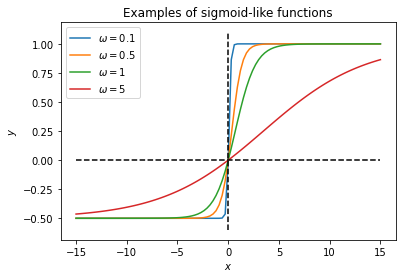

In [0]:
import numpy as np
import matplotlib.pyplot as plt

f_min = -0.5
f_max = 1.0

def sigmoid_like(x, omega):
  y = np.exp(-x/omega)
  return f_min + (f_max - f_min)/(1 - (f_max/f_min) * y)

x = np.linspace(-15, 15, 101)
y = sigmoid_like(x, 0.1)

plt.plot(x, sigmoid_like(x, 0.1), label = r'$\omega = 0.1$')
plt.plot(x, sigmoid_like(x, 0.5), label = r'$\omega = 0.5$')
plt.plot(x, sigmoid_like(x, 1), label = r'$\omega = 1$')
plt.plot(x, sigmoid_like(x, 5), label = r'$\omega = 5$')
plt.plot([-15, 15], [0, 0], '--', color = 'black')
plt.plot([0, 0], [-0.6, 1.1], '--', color = 'black')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.legend()
plt.title('Examples of sigmoid-like functions')

## Application of ASGD

Although equation (9) allowed us to fix $\alpha$, we still have five more parameters to choose before we implement the algorithm. They are 1) $a$, 2) $A$, 3) $f_{MIN}$, 4) $f_{MAX}$ and 5) $\omega$. The following assumptions will aid in selecting their values.



*   **Assumption B1** The errors $\boldsymbol{\epsilon}_k$ in equation (5) are assumed to be independent and identically distributed with mean zero and a finite variance. This tutorial also assumes that they are normally distributed.
*   **Assumption B2** The gain function $\gamma$ is positive and monotone descreasing over $[0, \infty)$. Thus, $\gamma(0)$ is its minimum. It has two additional properties
$$
\begin{eqnarray}
\int_0^\infty \gamma(t)dt &=& \infty \tag{12} \\
\int_0^\infty \gamma^2(t) dt &<& \infty \tag{13}
\end{eqnarray}
$$
*   **Assumption B3** The cost function $\mathcal{C}$ has a unique minimum $\hat{\boldsymbol{\mu}}$. That is $\mathcal{C}$ is a **convex function**. $\mathcal{C}$ is also assumed to be twice differentiable throughout its domain (differentiability guarantees continuity) and for all $\boldsymbol{\mu}$, the eigenvalues of the hessian
$$\tag{14}
\boldsymbol{H} = \frac{\partial^2\mathcal{C}}{\partial\mu_i\partial\mu_j}
$$
are bounded by a positive constant $\lambda$. The optimization problem then can be solved for all starting points $\boldsymbol{\mu}_0$ as long as $\gamma_k < \gamma(0)$ for all $k$. It is further assumed that there exists $R > 0$, $\beta_0 > 0$ such that 
$$\tag{15}
||\boldsymbol{g}(\boldsymbol{\mu})||^2 > \frac{\gamma(0)}{2}\lambda(||\boldsymbol{g}(\boldsymbol{\mu})||^2 + \mathrm{tr}(\boldsymbol{\Sigma})) + \beta_0,
$$
where $\boldsymbol{\Sigma}$ is the variance matrix of the errors $\boldsymbol{\epsilon}_k$ and $\mathrm{tr}(\cdot)$ stands for the trace operator. Equation (15) is true for all $\boldsymbol{\mu}$ that satisfy the relation $||\boldsymbol{\mu} - \hat{\boldsymbol{\mu}}|| \ge R$.
 
*   **Assumption B4** The function $f$ is monotone increasing, continuous and bounded with $f_{MAX} > 0$ as the maximum and $f_{MIN}$ as the minimum. It is also assumed that 
$$\tag{16}
E_0 = \mathbb{E}f(\boldsymbol{\epsilon}_k^T\boldsymbol{\epsilon}_{k-1}) > 0.
$$
*   **Assumption B5** These assumptions are necessary to prove asymptotic normality,
$$\tag{17}
\gamma(t) = \frac{a}{t + A}.
$$
and the eigenvalues of the matrix 
$$\tag{18}
\boldsymbol{W} = \frac{\boldsymbol{I}}{2} - \frac{a}{E_0}\boldsymbol{H}(\hat{\boldsymbol{\mu}})
$$
are positive. Here $E_0$ is defined by equation (16)




## Distribution estimates

We need some more assumptions about the distributions of the gradients in order to choose the correct values of the five parameters mentioned in the previous section. We mention them in this section.

A general cost function is of the form
$$\tag{19}
\mathcal{C} = \Psi\left(\frac{1}{|\Omega^\prime_F|}\sum_{x_i \in \Omega^\prime_F}\xi(F(x_i), M(T(x_i, \mu)))\right),
$$
where $\Psi: \Xi \mapsto \mathbb{R}$ and $\xi: \mathbb{R} \times \mathbb{R} \mapsto \Xi$ are differentiable functions, $\Omega^\prime_F$ is the is a subset of pixels/voxels of the fixed image and $|\Omega^\prime_F|$ is its cardinality. Usually, $\Xi = \mathbb{R}$ but it can be a multi-dimensional set like $\mathbb{R}^P$.

An example of these functions and domains is $\Xi = \mathbb{R}$, $\xi(u, v) = (u - v)^2)$ and $\Psi(w) = w$. 

The ASGD algorithm requires the gradient of the cost function. It is
$$\tag{20}
\boldsymbol{g} = \frac{\partial\mathcal{C}}{\partial\boldsymbol{\mu}} = 
\frac{1}{|\Omega^\prime_F|}\sum_{x_i \in \Omega^\prime_F}\left(\frac{\partial T}{\partial\boldsymbol{\mu}}\right)^T\frac{\partial M}{\partial\boldsymbol{x}}\frac{\partial\xi}{\partial v}\frac{\partial\Psi}{\partial u}.
$$

In order to estimate the distribution of the gradients, we need two more assumptions.


*   **Assumption A1** $\left({\partial T}/{\partial\boldsymbol{\mu}}\right)$  is independent of $\boldsymbol{\mu}$. That is, $T$ is a linear function of the parameters $\boldsymbol{\mu}$. Note the similarity of this assumption with that of linear models in statistics. We define
$$\tag{21}
\boldsymbol{J}_i = \frac{\partial T}{\partial\boldsymbol{\mu}}(x_i, \boldsymbol{\mu}).
$$
*   **Assumption A2** If
$$\tag{22}
z_i = \frac{\partial M}{\partial\boldsymbol{x}}\frac{\partial\xi}{\partial v}\frac{\partial\Psi}{\partial u}
$$
then $z_i$ are normally distributed with parameters $0$ and $\sigma^2\boldsymbol{I}$ for some constant $\sigma$. 

With these assumptions the it can be shown that
$$
\begin{eqnarray}
\boldsymbol{g} &\sim& \mathcal{N}(0, \sigma_1^2 C) \tag{23} \\
\tilde{\boldsymbol{g}}_k &\sim& \mathcal{N}(0, \sigma_1^2 C) \tag{24} \\
{\boldsymbol{\epsilon}}_k &\sim& \mathcal{N}(0, \sigma_3^2 C), \tag{25}
\end{eqnarray}
$$
where $\sigma_1^2, \sigma_2^2$ and $\sigma_3^2$ are constants and
$$\tag{26}
C = \frac{1}{|\Omega^\prime_F|}\sum_{x_i \in \Omega^\prime_F}\boldsymbol{J}_i^T\boldsymbol{J}_i
$$
The quantity $\boldsymbol{J}_i$ is defined in equation (21).
We further define,
$$\tag{27}
\boldsymbol{\Sigma} = \sigma_3^2 C.
$$



# Implementation of AGSD

We will implement the algorithm on two binary images that we generate in the code snippet below.

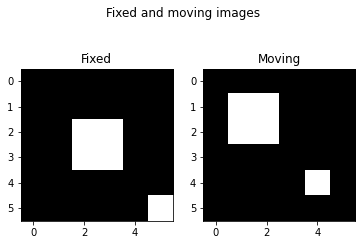

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

f = np.zeros(36)
f[14] = f[15] = f[20] = f[21] =  f[35] = 128
ref = Image.new('1', (6, 6))
ref.putdata(f)

m = np.zeros(36)
m[7] = m[8] = m[13] = m[14] = m[28] = 128
tst = Image.new('1', (6, 6))
tst.putdata(m)

plt.figure()
plt.suptitle('Fixed and moving images')
p1 = plt.subplot(121)
p1.set_title('Fixed')
plt.imshow(ref)

p2 = plt.subplot(122)
p2.set_title('Moving')
plt.imshow(tst)

plt.show()

## Estimation of parameters

The five parameters mentioned in section <a href='Application of ASGD'>Application of ASGD</A> are estimated for a run of the algorithm. We do so in the steps below. Before we do so, we choose the user defined quantities.

### User-defined quantities

1.   We work with linear transformations of the form $$\tag{28}
T(x) = \mu_0 + \mu_1 x
$$ where $\mu_0, \mu_1$ are the parameters of $T$. Thus, the goal of the optimization is to find the best values of these parameters so that when we apply $T$ to the moving image we get as close to the fixed image as possible. With this choice, our parameter space becomes $\mathbb{R}^2$ and our parameter vector becomes
$$\tag{29}
\boldsymbol{\mu} = (\mu_0, \mu_1).
$$
2.   Choose
$$\tag{30}
\delta = 0.1.
$$
This quantity was not introduced before. It appears in the theory of estimation of probability distribution of the gradients. We will find it useful while estimating the parameters of the ASGD algorithm.



### Estimation of parameters


#### Computation of $C$.
We use equation (26) to determine $C$. The set of all pixels of the fixed images has cardinality $36$. (Recall that we have generated $6 \times 6$ binary images.) Therefore, $|\Omega_F^\prime| = 36$. From equation (28), the gradient of $T$ in the $\mu$-space is 
$$\tag{31}
\boldsymbol{J}_i = \begin{pmatrix}1 & x_i\end{pmatrix}
$$
so that
$$\tag{32}
\boldsymbol{J}_i^T \boldsymbol{J}_i = \begin{pmatrix}1 & x_i \\ x_i & x_i^2\end{pmatrix}
$$
and
$$\tag{33}
\boldsymbol{C}(x_i) = \sum_{x_i \in \Omega_F^\prime} \begin{pmatrix}1 & x_i \\ x_i & x_i^2\end{pmatrix}.
$$
The code snippet below computes $C$.

In [2]:
# This code snippet cannot be run independently. Please run all the cells above 
# before getting here.

x = f - m # This is the "error" between the images.
C = np.array([[36, np.sum(x)], [np.sum(x), np.sum(x**2)]])/36
print(f'C = {C}')

C = [[1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.64088889e+03]]


#### Computation of $\sigma_4$
$\sigma_4$ too has not been introduced before and like $\delta$ it appears in the theory of distributions of the gradients. It is defined as
$$\tag{34}
\sigma_4^2 = \min_{x_j \in \Omega_F^\prime}\frac{\delta^2}{||\boldsymbol{J}_j||_F^2 + 2\sqrt{2}||\boldsymbol{J}_j\boldsymbol{J}_j^T||_F},
$$
where $||\cdot||_F$ stands for [Frobenius norm](https://mathworld.wolfram.com/FrobeniusNorm.html). Recall that we have selected $\delta = 0.1$ in equation (30). From equation (31) it is clear that
$$\tag{35}
\boldsymbol{J}_j\boldsymbol{J}_j^T = 1 + x_j^2
$$
so that
$$\tag{36}
||\boldsymbol{J}_j\boldsymbol{J}_j^T||_F = \sqrt{(1 + x_j^2)^2} = 1 + x_j^2.
$$
Similarly
$$\tag{37}
||\boldsymbol{J}_i||_F = \sqrt{1 + x_j^2}.
$$
Equation (34) now becomes
$$\tag{38}
\sigma_4^2 = \min_{x_j \in \Omega_F^\prime}\frac{\delta^2}{1 + x_j^2 + 2\sqrt{2}(1 + x_j^2)} = \frac{1}{(1 + 2\sqrt{2})}\min_{x_j \in \Omega_F^\prime}\frac{\delta^2}{(1 + x_j^2)}
$$
We compute $\sigma_4$ in the code snippet below.

In [3]:
# This code snippet cannot be run independently. Please run all the cells above 
# before getting here.

DELTA = 0.1
den_sigma_4 = np.zeros(len(x))
delta_sq = DELTA**2

for j in range(0, len(den_sigma_4)):
  a = 1 + x[j]**2
  den_sigma_4[j] = delta_sq/a

sigma_4_sq = np.min(den_sigma_4)/(1 + 2 * np.sqrt(2))
sigma_4 = np.sqrt(sigma_4_sq)
print(f'\sigma_4 = {sigma_4}')
  

\sigma_4 = 0.00039926991272375335


#### Computation of approximate error
We generate $N = 20$ instances of $\boldsymbol{\mu}$ distributed as $\mathcal{N}(0, \sigma_4^2\boldsymbol{I})$

In [0]:
# This code snippet cannot be run independently. Please run all the cells above 
# before getting here.
from scipy import stats

# This is our starting vector
mu_0 = np.array([0, 0])
cov = np.array([[sigma_4_sq, 0], [0, sigma_4_sq]])
mu_samples = []
N = 20 # number of samples

frozen = stats.multivariate_normal(mu_0, cov)
mu_samples = frozen.rvs(10)


For each randomly generated $\boldsymbol{\mu}$ compute the exact gradient $\boldsymbol{g}$. Computation of gradient requires a knowledge of the cost function. Let us choose a commonly used cost function - sum of squares of error terms. Thus, 
$$\tag{39}
C(F, M) = \sum_{i = 0}^{36} (F_i - M_i)^2,
$$
where $F_i = F[i]$ and so on. 
Note that this is true only for our choice of $6 \times 6$ binary images. Further, since we chose $T(x) = mu_0 + \mu_1 x$ in equation (28), <code>M[x_i] = mu[0] + mu[1] * F[x_i]</code>. Equation (39) thus becomes
$$\tag{40}
C(F, M) = \sum_{i=0}^{36} ((1 - \mu_1)F_i - \mu_0)^2
$$
and its gradient is
$$\tag{41}
\boldsymbol{g} = \sum_{i=0}^{36} \begin{pmatrix}-2((1 - \mu_1)F_i - \mu_0) \\ -2F_i((1 - \mu_1)F_i - \mu_0) \end{pmatrix} = -2\sum_{i=0}^{36} ((1 - \mu_1)F_i - \mu_0)\begin{pmatrix}1 \\ F_i\end{pmatrix}
$$
The approximate gradient is
$$\tag{42}
\tilde{\boldsymbol{g}} = -2\sum_{i \in S} ((1 - \mu_1)F_i - \mu_0)\begin{pmatrix}1 \\ F_i\end{pmatrix},
$$
where $S$ is a small sample of the set $\{0, \ldots, 35\}$. (We are counting from zero to make it easy for us to translate this theory into code.)



In [0]:
# This code snippet cannot be run independently. Please run all the cells above 
# before getting here.
import random

random.seed(12111842)

exact_g = []
apprx_g = []
error_g = []

for i in range(len(mu_samples)):
  mu = mu_samples[i]
  g = np.zeros(2)
  for j in range(len(x)):
    # Recall that the data for the fixed image is in the array x
    X = np.array([1, x[j]]) 
    coeff = -2 * ((1 - mu[1]) * x[j] - mu[0])
    g = g + coeff * X

  exact_g.append(g)

for i in range(len(mu_samples)):
  mu = mu_samples[i]
  g = np.zeros(2)
  # Select a new set of pixels for computation of each approximate gradient
  S = random.sample(range(0, 36), N)
  for j in range(len(S)):
    # Recall that the data for the fixed image is in the array x
    X = np.array([1, x[j]]) 
    coeff = -2 * ((1 - mu[1]) * x[j] - mu[0])
    g = g + coeff * X

  apprx_g.append(g)

for i in range(len(mu_samples)):
  error_g.append(exact_g[i] - apprx_g[i])

Compute $\sigma_1^2$ as
$$\tag{43}
\sigma_1^2 = \frac{1}{\mathrm{tr}(\boldsymbol{C})}\frac{1}{N}\sum_{n=1}^N||\boldsymbol{g}_n||^2.
$$
Recall the definition of $\boldsymbol{C}$ in equation (33). We compute $\sigma_1^2$ in the cell below.

In [6]:
# This code snippet cannot be run independently. Please run all the cells above 
# before getting here.

trace_C = C[0, 0] + C[1, 1]

s = 0 
for i in range(len(exact_g)):
  g_n = exact_g[i]
  s = s + g_n[0]**2 + g_n[1]**2

sigma_1_sq = 1/(N * trace_C)
print(f'sigma_1_sq = {sigma_1_sq}')

sigma_1_sq = 1.3729139335509656e-05


Compute $a_{MAX}$ using the relation
$$\tag{44}
a_{MAX} = \frac{A\delta}{\sigma_1}\min_{x_j \in \Omega_F^\prime}\left[\mathrm{tr}(\boldsymbol{J}_j\boldsymbol{C}\boldsymbol{J}_j^T) + 2\sqrt{2}||\boldsymbol{J}_j\boldsymbol{C}\boldsymbol{J}_j^T||_F\right]^{-1/2}
$$
Recall that we had chosen $\delta = 0.1$ in equation (30). $A$ is another free parameter. Let us choose
$$\tag{45}
A = 1.
$$
We computed the matrix $\boldsymbol{C}$ in equation (33) and $\boldsymbol{J}_j$ in equation (30). Based on these we can calculate
$$\tag{46}
\boldsymbol{J}_j\boldsymbol{C}\boldsymbol{J}_j^T = 1 + 3.64 \times 10^3 \times x_j^4
$$
Since this is just a number, it is the same as its trace and Frobenius norm. Equation (44) then becomes
$$\tag{47}
a_{MAX} = \frac{A\delta}{\sigma_1}\min_{x_j \in \Omega_F^\prime}\frac{1}{\sqrt{(1 + 2\sqrt{2})(1 + 3.64 \times 10^3 \times x_j^4)}}
$$
The code snippet below computes $a_{MAX}$.

In [7]:
# This code snippet cannot be run independently. Please run all the cells above 
# before getting here.

all_a = np.zeros(len(x))
sigma_1 = np.sqrt(sigma_1_sq)
coeff = 0.1 / sigma_1

for i in range(len(x)):
  a = (1 + 2 * np.sqrt(2)) * (1 + 3.64 * 1E3 * x[i]**4)
  all_a[i] = coeff/np.sqrt(a)

a_max = np.min(all_a)
print(f'a_max = {a_max}')

a_max = 1.3953961495741212e-05


Compute $\eta$ and $a$ using the equations
$$\tag{48}
\eta = \frac{\mathbb{E}||\boldsymbol{g}||^2}{\mathbb{E}||\boldsymbol{g}||^2 + \mathbb{E}||\tilde{\boldsymbol{g}}||^2}
$$
and
$$\tag{48}
a = a_{MAX} \cdot \eta.
$$
Also
$$\tag{49}
f_{min} = \eta - 1.
$$
We compute these quantities now.

In [8]:
# This code snippet cannot be run independently. Please run all the cells above 
# before getting here.
s1 = 0
s2 = 0
for i in range(len(exact_g)):
  g = exact_g[i]
  h = apprx_g[i]

  s1 = s1 + (g[0]**2 + g[1]**2)
  s2 = s2 + (h[0]**2 + h[1]**2)

eta = s1/(s1 + s2)
a = a_max * eta
f_min = eta - 1

print(f'eta = {eta}')
print(f'a = {a}')
print(f'f_min = {f_min}')


eta = 0.7999973773111878
a = 1.1163132599694269e-05
f_min = -0.2000026226888122


The quantity $\omega$ is computed as
$$\tag{50}
\omega = \zeta \sqrt{\mathrm{Var}(\boldsymbol{\epsilon}_k\boldsymbol{\epsilon}_{k-1})}.
$$
We compute it in the cell below.

In [9]:
# This code snippet cannot be run independently. Please run all the cells above 
# before getting here.

err_prod = np.zeros(len(error_g) - 1)
zeta = 0.1

for i in range(1, len(error_g)):
  e1 = error_g[i]
  e2 = error_g[i - 1]
  err_prod[i - 1] = np.dot(e1, e2)

print(err_prod)

omega = zeta * np.std(err_prod)
print(f'omega = {omega}')


[1.71862149e+10 1.71959182e+10 1.71800672e+10 1.71756754e+10
 1.71758954e+10 1.71807175e+10 1.71735969e+10 1.71727391e+10
 1.71883437e+10]
omega = 731878.7214182274


We are now in a position to compute the function $f$ defined by equation (11). We also can write
$$\tag{51}
\gamma(x) = \frac{a}{x + 1}
$$
because of our choice of $A = 1$ and $\alpha = 1$. We now have all the information needed to run the algorithm described by equations (4), (5) and (6).
This allows us to implement the algorithm in then ext cell.

In [23]:
def our_sigmoid(x):
  # Recall that f_max = 1
  return f_min + (1 - f_min)/(1 - np.exp(-x/omega)/f_min)

def calc_t(prev_t, g_curr, g_prev):
  arg = prev_t + our_sigmoid(np.dot(g_curr, g_prev))
  if arg > 0:
    return arg
  else:
    return 0

# We re-initialize the image data
f = np.zeros(36)
f[14] = f[15] = f[20] = f[21] =  f[35] = 128
m = np.zeros(36)
m[7] = m[8] = m[13] = m[14] = m[28] = 128
# 'Difference' between fixed and moving images.
x = f - m

# Parameters of the algorithm
MAX_ITER = 100 # Maximum number of iterations.
n_iter = 0     # Current iteration.

# Temporary variables
g_prev = np.array([1, 1]) # previous gradient
mu_prev = np.zeros(2)     # previous parameters
prev_t = 0                # previous 'time'

while n_iter < MAX_ITER:
  n_iter = n_iter + 1
  m = mu_prev[0] + mu_prev[1] * f
  
  # Select a new set of pixels for computation of each approximate gradient
  S = random.sample(range(0, 36), 15)
  g = np.zeros(2)
  for j in range(len(S)):
    # Recall that the data for the fixed image is in the array x
    X = np.array([1, x[j]]) 
    coeff = -2 * ((1 - mu[1]) * x[j] - mu[0])    
    g = g + coeff * X
  
  curr_t = calc_t(prev_t, g, g_prev)  
  gamma = a_max/(curr_t + 1) # Recall that A = 1, alpha = 1

  mu_prev = mu_prev + gamma * g
  g_prev = g
  prev_t = curr_t
  
print(f'mu = {mu_prev}')


mu = [  0.1049243 -13.4303987]
